# **Import required libraries**

In [ ]:
! pip install facets-overview
! pip install dtreeviz
! pip install shap
! pip install eli5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics 
import warnings

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import dtreeviz
import eli5
import shap
from sklearn.datasets import *
from sklearn import tree
from dtreeviz.trees import *

import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
import seaborn 
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.manifold.t_sne import TSNE
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
import base64
from IPython.core.display import display, HTML
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from IPython.core.display import display, HTML


# **Preprocessing and generating the Dataset**


In [ ]:
class Preprocessing:
  def __init__(self, folder_path, number_of_samples, labels):
    """ Preprocessing and Labeling data """
    self.df = pd.DataFrame(columns=["X_leg", "Y_leg", "Z_leg", "X_arm", "Y_arm", "Z_arm", "label"])
    self.labels = labels
    self.read_data(folder_path, number_of_samples)
    self.df = self.df.reset_index()
    self.df = self.df.drop("index", axis=1)
    self.df.to_csv("dataset.csv")

  def data_collection(self, csv_arm_df, csv_leg_df, label):
    arm_data = csv_arm_df.apply(np.mean, axis=0).values
    leg_data = csv_leg_df.apply(np.mean, axis=0).values
      
    data = pd.DataFrame({
        "X_leg": [leg_data[0]],
        "Y_leg": [leg_data[1]],
        "Z_leg": [leg_data[2]],
        "X_arm": [arm_data[0]],
        "Y_arm": [arm_data[1]],
        "Z_arm": [arm_data[2]],
        "label": [label]
    })  


    self.df = self.df.append(data)


  def read_data(self,folder_path, number_of_samples):
    for i in range(1, number_of_samples + 1):
      csv_arm = os.path.join(folder_path, f"Arm{i}.csv")
      csv_leg = os.path.join(folder_path, f"Leg{i}.csv")
      csv_arm_df = pd.read_csv(csv_arm)
      csv_arm_df = csv_arm_df[["AccX", "AccY", "AccZ"]]
      csv_leg_df = pd.read_csv(csv_leg)
      csv_leg_df = csv_leg_df[["AccX", "AccY", "AccZ"]]
      self.data_collection(csv_arm_df, csv_leg_df, self.labels[i-1])
    

In [ ]:
labels = pd.read_csv("/content/labels.csv")
labels = list(labels["Score"])
len(labels)

142

In [ ]:
#@title Arguments
Number_of_Shots = 142 #@param {type:"number"}
df = Preprocessing("/content/drive/MyDrive/SL_FINAL", Number_of_Shots, labels=labels) # 0 for miss/ 1 for goal 

# **Reading the data, EDA**

In [ ]:
data = pd.read_csv ("/content/dataset.csv")
data = data[['X_leg', 'Y_leg', 'Z_leg', 'X_arm','Y_arm', 'Z_arm', 'label']]

In [ ]:
data.shape

(142, 7)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6fd2aa390>,
      dtype=object)

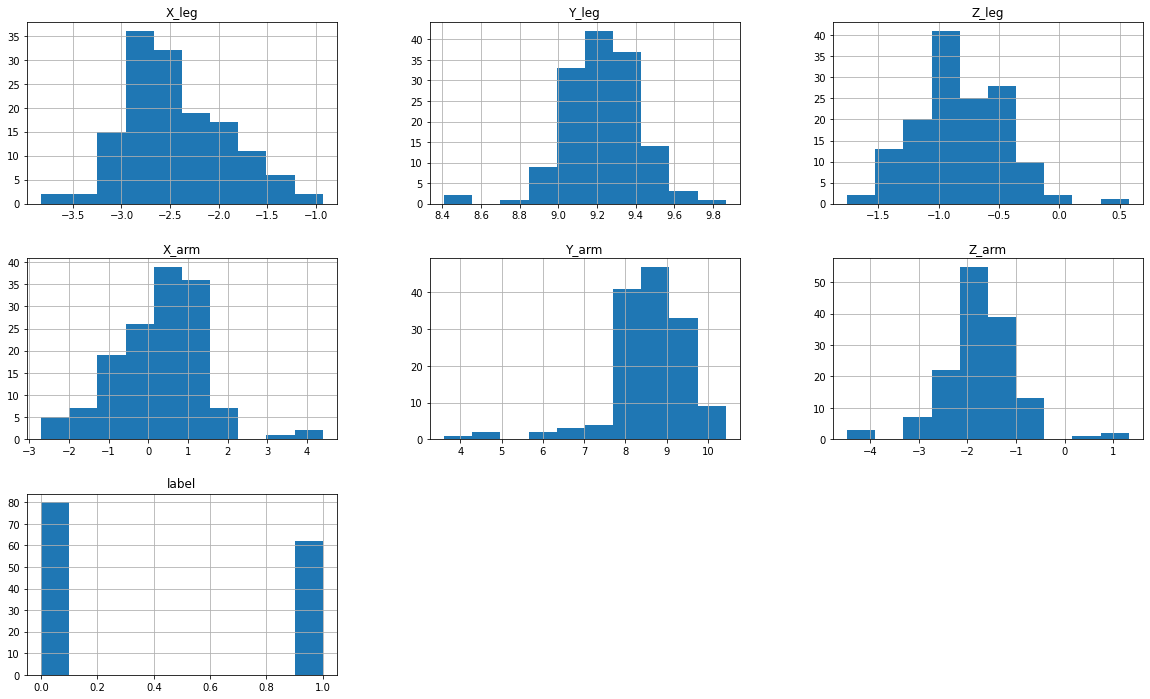

In [ ]:
data.hist(figsize=(20, 12))

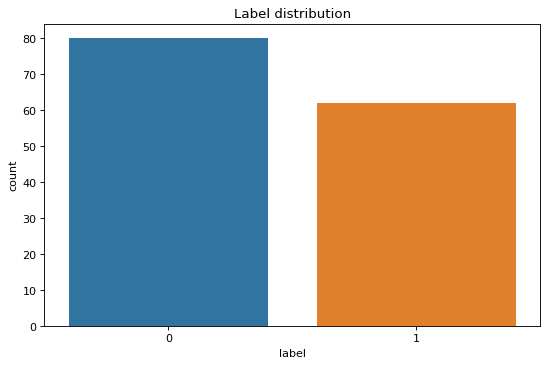

In [ ]:
# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
warnings.filterwarnings('ignore', category=DeprecationWarning)
plt.figure(figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
sns.countplot(x='label', data=data, ax=ax);
ax.set_title('Label distribution')
plt.show()

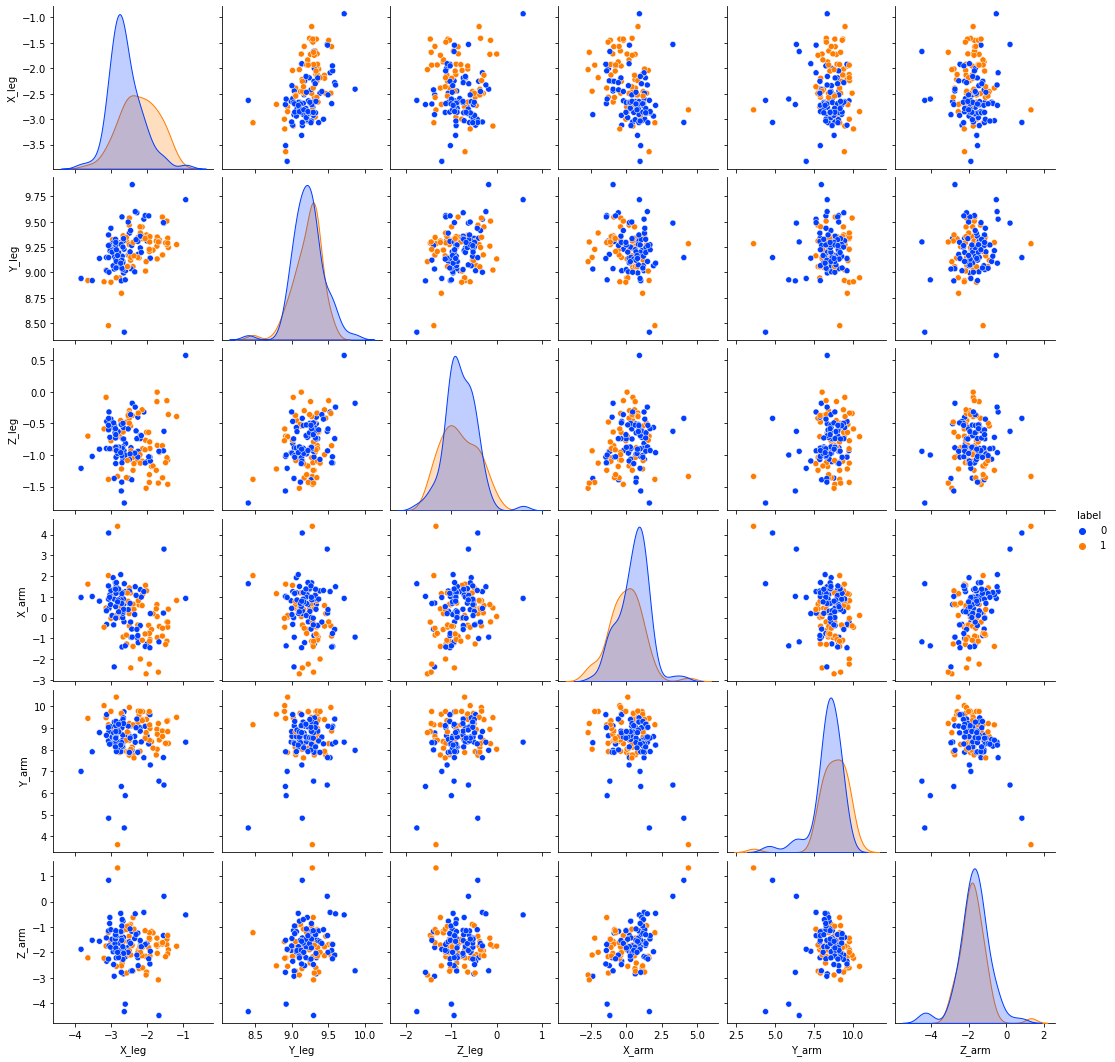

In [ ]:
sns.pairplot(data, hue="label",palette="bright")

Text(0.5, 1.0, 'Pearson Correlation')

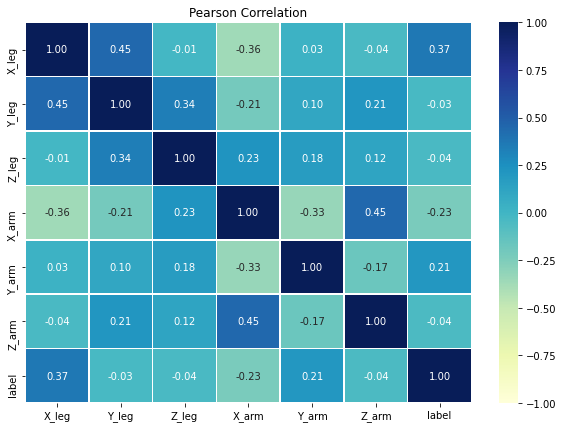

In [ ]:
corr_matrix = data.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Pearson Correlation")

# **Explaining Machine Learning with Facets**



**Facets Drive**

The ability to verify the ground truth of data distributions is critical in supervised learning. Supervised ML involves training datasets with labels. These labels constitute the target values. An ML algorithm will be trained to predict them. However, some or all of the labels might be wrong. The accuracy of the predictions might not be sufficient.
With Facets Dive, we can explore a large number of data points interactively and analyze their relationships.

In [ ]:
jsonstr = data.to_json(orient='records')
jsonstr

'[{"X_leg":-2.5204284391,"Y_leg":9.1705630493,"Z_leg":-1.366449363,"X_arm":0.7046241205,"Y_arm":8.7741676608,"Z_arm":-1.8030580971,"label":0},{"X_leg":-2.9571124508,"Y_leg":9.3228052615,"Z_leg":-0.9010907788,"X_arm":1.0340313873,"Y_arm":8.9727959747,"Z_arm":-1.7370344849,"label":1},{"X_leg":-2.2204249103,"Y_leg":9.1423230567,"Z_leg":-1.0193552399,"X_arm":0.6172164917,"Y_arm":9.6178841224,"Z_arm":-2.6324028133,"label":1},{"X_leg":-1.5307696892,"Y_leg":9.4867486752,"Z_leg":-0.6253613191,"X_arm":3.3019703594,"Y_arm":6.3647591521,"Z_arm":0.2090941339,"label":0},{"X_leg":-2.6505967513,"Y_leg":8.9943852101,"Z_leg":-0.9646071326,"X_arm":0.8154625702,"Y_arm":8.3572647285,"Z_arm":-1.9196476555,"label":0},{"X_leg":-3.0689083895,"Y_leg":8.4739761021,"Z_leg":-1.3861240619,"X_arm":2.025957408,"Y_arm":9.1553501269,"Z_arm":-1.2224711235,"label":1},{"X_leg":-2.6380850417,"Y_leg":9.2291474053,"Z_leg":-0.9296949153,"X_arm":-0.2005828857,"Y_arm":9.7528680253,"Z_arm":-1.8718527746,"label":0},{"X_leg":-2.7

In [ ]:
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/
webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/
PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""

In [ ]:
html = HTML_TEMPLATE.format(jsonstr=jsonstr)

In [ ]:
display(HTML(html))

# **Feature engineering**

In [ ]:
def feature_engineering(data):
  data["leg_force"]=(data["X_leg"]**2+data["Y_leg"]**2+data["Z_leg"]**2)**(0.5)
  data["arm_force"]=(data["X_arm"]**2+data["Y_arm"]**2+data["Z_arm"]**2)**(0.5)

  data["leg_arm_force_sum"]=data["arm_force"]+data["leg_force"]
  data["leg_arm_force_difference"]=data["arm_force"]-data["leg_force"]

  data["X_force"]=(data["X_leg"]**2+data["X_arm"]**2)**(0.5)
  data["Y_force"]=(data["Y_leg"]**2+data["Y_arm"]**2)**(0.5)
  data["Z_force"]=(data["Z_leg"]**2+data["Z_arm"]**2)**(0.5)

  return data

In [ ]:
data=feature_engineering(data)

In [ ]:
data.head()

X_leg     Y_leg     Z_leg  ...   X_force    Y_force   Z_force
0 -2.520428  9.170563 -1.366449  ...  2.617070  12.691936  2.262344
1 -2.957112  9.322805 -0.901091  ...  3.132688  12.939311  1.956848
2 -2.220425  9.142323 -1.019355  ...  2.304613  13.269731  2.822876
3 -1.530770  9.486749 -0.625361  ...  3.639542  11.424034  0.659391
4 -2.650597  8.994385 -0.964607  ...  2.773201  12.277738  2.148375

[5 rows x 14 columns]

#**Splitting**

In [ ]:
def train_test(data,test_percentage):
  split=StratifiedShuffleSplit(n_splits=1,test_size=test_percentage,random_state=40)
  for train_index,test_index in split.split(data,data["label"]):
    train_set=data.loc[train_index]
    test_set=data.loc[test_index]

  X_train2=train_set.copy()
  X_train=X_train2.drop('label', axis=1)
  Y_train=train_set["label"].copy()

  X_test2=test_set.copy()
  X_test=X_test2.drop('label', axis=1)
  Y_test=test_set["label"].copy()

  return X_train,Y_train,X_test,Y_test     

In [ ]:
X_train,Y_train,X_test,Y_test=train_test(data,0.2)

In [ ]:
X_train.head()

X_leg     Y_leg     Z_leg  ...   X_force    Y_force   Z_force
79  -2.188786  9.357716 -0.739861  ...  2.221283  12.885413  1.698814
110 -2.649515  9.333624 -0.746878  ...  2.680370  13.112581  2.166744
41  -1.179998  9.274592 -0.390905  ...  1.442841  13.274201  1.797120
109 -2.159508  9.197896 -0.692992  ...  2.376201  12.429933  1.905515
89  -2.053625  9.334332 -0.917787  ...  2.197957  12.636880  1.466684

[5 rows x 13 columns]

In [ ]:
print(X_train.shape)
print(X_test.shape)

(113, 13)
(29, 13)


**Explaining Machine Learning with Facets**

Facets provides a wide range of statistics for each feature of a dataset. Facets will help us detect missing data, zero values, non-uniformity in data distributions, and more, so it's fun to implement and take a look.

In [ ]:
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train',
                                   'table': X_train},
                                  {'name': 'test',
                                   'table': X_test}])
protostr = base64.b64encode(proto.SerializeToString()).decode(
    "utf-8")

In [ ]:
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/
webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/
PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)

In [ ]:
display(HTML(html))

#**Normalizing the data**

In [ ]:
def normalize(X_train,X_test):
  norm_X_train=(X_train-X_train.mean())/(X_train.max()-X_train.min())
  norm_X_test=(X_test-X_test.mean())/(X_test.max()-X_test.min())
  return norm_X_train,norm_X_test

In [ ]:
norm_X_train,norm_X_test = normalize(X_train,X_test)
norm_X_train.head()

X_leg     Y_leg     Z_leg  ...   X_force   Y_force   Z_force
79   0.088267  0.092276  0.032518  ... -0.123870  0.065889 -0.070807
110 -0.070642  0.075741  0.029517  ... -0.006507  0.118685  0.042423
41   0.436205  0.035226  0.181798  ... -0.322873  0.156248 -0.047019
109  0.098365 -0.017413  0.052569  ... -0.084266 -0.039969 -0.020790
89   0.134885  0.076227 -0.043596  ... -0.129833  0.008128 -0.126979

[5 rows x 13 columns]

# **Linear model**

As well known, linear models are often used and implemented because of their simplicity and their innate capability to express the importance of each predictor in regression or classification (as in our framework) tasks: the importance of each predictor is indeed expressed by the magnitude of the coefficient associated to each single predictor. We will so fit a linear model over the standard gaussian normalized data with stochastic gradient descent learning and dive in its interpretation.

In [ ]:
#Define linear classifier function. It returns array of prediction and fitted model
def linear_classifier(train,train_labels,test):
  linear_mod = linear_model.SGDClassifier(random_state=42)
  # random.seed(11)
  linear_mod.fit(train, train_labels)
  prediction = linear_mod.predict(test)
  return prediction,linear_mod

In [ ]:
#Compute prediction over the test set
random.seed(10)
Y_linear_pred,model=linear_classifier(norm_X_train,Y_train,norm_X_test)

#Save coefficients + intercept values
coefficients=model.coef_[0,]
intercept=model.intercept_


Confusion matrix
[[14  2]
 [ 2 11]]


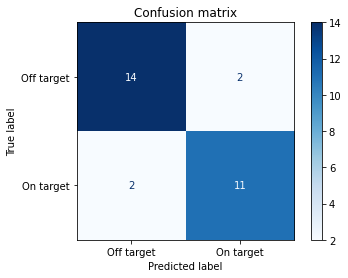

In [ ]:
#Define class names
class_names=("Off target","On target")
#Plot confusion matrix
title=("Confusion matrix")

disp = plot_confusion_matrix(model, norm_X_test, Y_test,
                              display_labels=class_names,
                              cmap=plt.cm.Blues)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [ ]:
#Save (for permutation feature importance purposes)
#and print fitted model accuracy over the test set
model_accuracy=metrics.accuracy_score(Y_test,Y_linear_pred)
print("Accuracy:",model_accuracy)


Accuracy: 0.8620689655172413


##**Feature importance interpretation in a linear model**

After the extrapolation of our linear model coefficients, we wish to find the greatest one in absolute value, which will be so associated to the most weighted predictor inside our model. We are so sorting our coefficients absolute values in ascending order, ploting through a bar plot the hierarchy of the predictors:

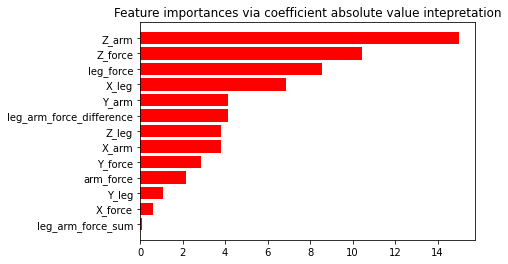

In [ ]:
#Save indexes of the coefficients ordered in ascending order w.r.t. their absolute values
indices = np.argsort(abs(coefficients))
#Save predictor names for bar plot purposes
names=norm_X_train.columns

# Plot the feature importances of the linear predictor (absolute values)
plt.figure()
plt.title("Feature importances via coefficient absolute value intepretation")
plt.barh(range(norm_X_train.shape[1]), abs(coefficients[indices]),
       color="r", align="center")
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()


##**Decision boundary plot**

Based on our linear model coefficient interpretation, we wish now to plot the decision hyperplane together with the data points in a 2 dimensional space. Of course, belonging our data to a 13 dimensional space, even if the 2 selected features for plotting purposes are between most important ones, we will in this way just retrieve a raw hyperplane representation. Let's go for it: 

(10000, 2)


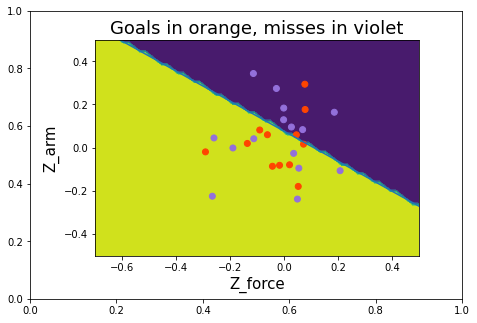

In [ ]:
#Define function to plot background in 2 feature space
def back_model(matrix,size,values):
  back=np.zeros(size)
  print(matrix.shape)
  for i in range(0,size):
    if matrix[i,1] > (0.5-values[0]-values[1]*matrix[i,0])/values[2]:
      back[i]=0
    else:
      back[i]=1
  return back
  
x = norm_X_test[names[indices][-2]]
y = norm_X_test[names[indices][-1]]
X=np.linspace(-1,1,100)
#Define hyperplane boundary
f=(0.5-intercept-coefficients[indices][-2]*X)/coefficients[indices][-1]
colors=["mediumpurple","orangered"]
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
#save hyperplane coefficients
values=(intercept,coefficients[indices][-2],coefficients[indices][-1])
resolution=100
xx, yy = np.meshgrid(np.linspace(-1,1, resolution), np.linspace(-1, 1, resolution))
#Identify decision areas 
back= back_model(np.c_[xx.ravel(), yy.ravel()],len(xx.ravel()),values)
back = back.reshape((resolution, resolution))
ax = fig.add_axes([0.15,0.15,0.75,0.75])

ax.contourf(xx, yy, back)
ax.scatter(x,y, c=Y_test,cmap=matplotlib.colors.ListedColormap(colors))
ax.plot(X,f)
ax.set_xlim(-0.7,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_xlabel(names[indices][-2],fontsize=15)
ax.set_ylabel(names[indices][-1],fontsize=15)
ax.set_title("Goals in orange, misses in violet",fontsize=18)
fig.savefig("boundary.pdf")
plt.show()

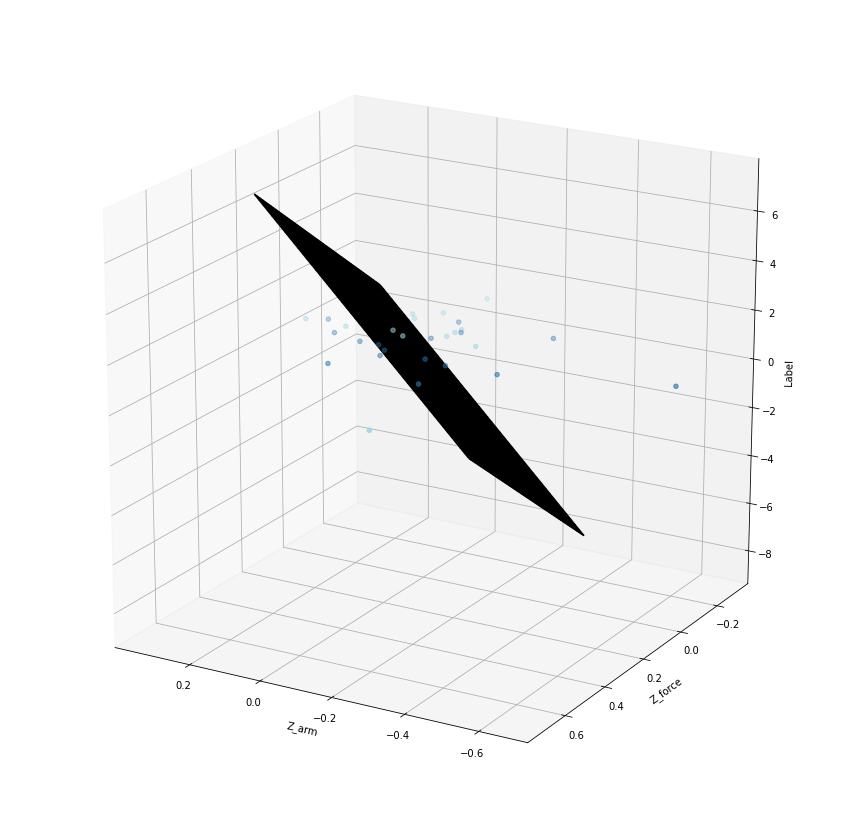

In [ ]:
#Define the function plotting the hyperplane over the 2 most important dimension
def f(indices,intercept,coefficients,x, y):
    #coefficients[indices][-1] select most importante feature,
    #coefficients[indices][-2] the second one
    return intercept+coefficients[indices][-1]*x+coefficients[indices][-2]*y

#norm_X_train[names[indices][-1]] select most important predictor ,
#norm_X_train[names[indices][-2]] the second one
x = norm_X_test[names[indices][-1]]
y = norm_X_test[names[indices][-2]]
z = Y_test


xx=np.linspace(-.3,0.3,50)
yy=np.linspace(-.3,0.3,50)

X, Y = np.meshgrid(xx, yy)
Z = f(indices,intercept,coefficients,X, Y)

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')

ax.scatter3D(x,y, Y_test, c=Y_test,cmap='tab20')
ax.set_xlabel(names[indices][-1])
ax.set_ylabel(names[indices][-2])
ax.set_zlabel('Label')
#ax.set_zlim(-1,2)
ax.view_init(20, 120);

Let's dive in a better representation of our 13 dimensional hyperplane. We are going to apply a non linear trasformation over 2 dimensional space to our test set through $\texttt{TSNE()}$ package. Then we are going to scatterplot those 2 components using a different color for the original label, and express our decisional hyperplane performing a KNN fit setting $\texttt{n_neighbours=1}$. Even if we will loose interpretability (being TSNE a non deterministic and randomized non linear mapping), it's the only way we can retrieve information of our hyperplane in the original 13-dimensional space:

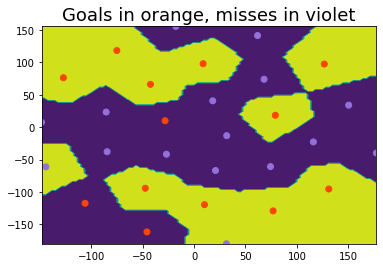

In [ ]:
#Perform prediction over the test set
Y_linear_pred,model=linear_classifier(norm_X_train,Y_train,norm_X_test)
#Embed our test set in a 2 dimensional space
X_embed = TSNE(n_components=2).fit_transform(norm_X_test)

colors=["mediumpurple","orangered"]
#Create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_embed[:,0]), np.max(X_embed[:,0])
X2d_ymin, X2d_ymax = np.min(X_embed[:,1]), np.max(X_embed[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))
# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_embed, Y_linear_pred) 
Background = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
Background = Background.reshape((resolution, resolution))
plt.title("Goals in orange, misses in violet",fontsize=18)

plt.contourf(xx, yy, Background)
plt.scatter(X_embed[:,0], X_embed[:,1],c=Y_test,cmap=matplotlib.colors.ListedColormap(colors))
plt.savefig("TSNE.pdf")
plt.show()

Once again, even if the projection of our 13-D hyperplane doesn't look linear in 2-D, we can appreciate how the confusion matrix values are preserved over this plot: we have respectively 2 misclassified datapoints over each class.

In [ ]:
Background.shape

(100, 100)

##**Permutation feature importance**

We wish now to implement from scratch another method to assess the importance associated with each predictor of our linear model. We are expecting to obtain results which are consistent with the ones obtained through the interpretation of the linear model coefficients. To do that we will implement the **feature permutation algorithm**. First of all we will save our model accuracy $s$ over the normal dataset. We will then perform $K$ random shuffling over the values of a single predictor (identified by letter $j$) at a time. After each of this $K$ shuffling, data are divided in train ant test and the accuracy of the original linear model is assessed over the shuffled test set and stored in the variable $s_{j,k}$. The importance of each predictor is then computed as follows:
$$
i_j=s-\frac{1}{K}\sum_{k=1}^{k=K}s_{j,k}
$$
Which basically mean that a predictor importance will be great if the shuffling of its values resulted in a low accurate model.

In [ ]:
#Define number of shuffling for each predictor
K=100
#Define support matrix to store models accuracies
accuracies = np.zeros((K,len(norm_X_train.columns)))
print(accuracies.shape)

(100, 13)


In [ ]:
#Define the nested loop to compute accuracy over shuffled data
for j,name in zip(range(len(norm_X_train.columns)),norm_X_train.columns):
  for k in range(K):
    #Perform a copy of original data
    data_shuffled=data.copy()
    #Randomly shuffle column indexed by the "name" index
    data_shuffled[name] = data[name].sample(frac=1).reset_index(drop=True)
    #Perform train_test split over shuffled data
    X_train,Y_train,X_test,Y_test=train_test(data_shuffled,0.2)
    #Normalize shuffled data
    norm_X_train,norm_X_test = normalize(X_train,X_test)

    fake_Y_train=Y_train.replace(2,1)
    fake_Y_test=Y_test.replace(2,1)
    #Perform prediction over the shuffled data
    Y_linear_pred=model.predict(norm_X_test)
    #Store accuracy for k-th shuffling and j-th predictor
    accuracies[k,j]=metrics.accuracy_score(fake_Y_test,Y_linear_pred)


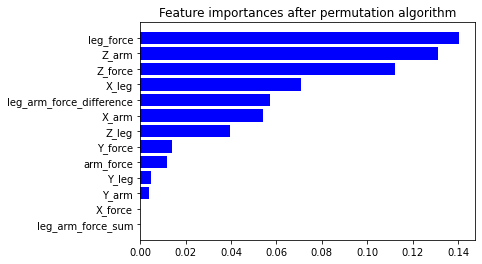

In [ ]:
#Compute mean accross the accuracies matrix rows in order to reduce random noise
mean_accuracies=accuracies.mean(axis=0)
#Compute predictors importances as per above mentioned formula
predictors_importances=model_accuracy-mean_accuracies
#Save indexes of the importances ordered in ascending order w.r.t. their values
index = np.argsort(predictors_importances)
#Save predictor names for bar plot purposes
names=norm_X_train.columns
# Plot the predictor importances of the linear predictor (absolute values)
plt.figure()
plt.title("Feature importances after permutation algorithm")
plt.barh(range(X_train.shape[1]), predictors_importances[index],
       color="b", align="center")
plt.yticks(range(X_train.shape[1]), names[index])
plt.ylim([-1, X_train.shape[1]])
plt.show()


As we can clearly see, the results are consistent with the simple interpretation of the linear model coefficient, letting us appreciate even more the innate interpretability power of linear models. Once again, $\texttt{leg_force}$, $\texttt{Z_arm}$ and $\texttt{Z_force}$ are on the podio of the 3 most weighted predictors in our classification task.

# **Descision Tree Classifier**

**Theoretical description of descision tree classifiers**

The descision tree uses Gini impurity values to classify the features of the record in a dataset node by node. The nodes at the top of the tree contain highest values of Gini impurity.
In our case if Gini value is **<= 3.71** for **X_force** then the child node on the left filters the true values, also note that the child node on the right is false for the **X_force** condition.
let `k` represent the probability of a data point being incorrectly classified. Let X represent the dataset we apply descision tree on. Then Gini impurity calculates the probability of each feature occuring and multiplies the result by 1, that is, the probability of occuring on the remaining values.
\begin{equation*}
G(k)   =  \sum_{i=1}^n  p_i*({ 1 - p_i})
\end{equation*}
The desicion tree is built on the gain of information on the features that contain the highest Gini impurity value. As the descison tree classifier calculates the Gini impurity at each node and creates child nodes, the descision tree's depth increases as depicted in the following plot.


*   criterion='gini': We are applying the Gini impurity algorithm. 
*   max_depth=None: There is no maximum depth that constricts the decision tree, which maximizes its size.
*  min_impurity_split=None: There is no minimum impurity split, which means that even small values will be taken into account. There is no constraint on expanding the size of a decision tree.







In [ ]:
# Model (can also use single decision tree)
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Train
clf.fit(norm_X_train, Y_train)
y_pred = clf.predict(norm_X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))


Accuracy: 0.7241379310344828


**The default output of the default structure of a decision tree**

The decision tree estimator contains a tree_ object that stores the attributes of the structure of a decision tree in arrays.


In [ ]:
clf.tree_

We can count the number of nodes.

In [ ]:
n_nodes = clf.tree_.node_count

In [ ]:
n_nodes

43

We can view the feature used to split the node into the left and right child nodes.

In [ ]:
feature = clf.tree_.feature

In [ ]:
feature

array([ 0,  9,  4, -2, 10, 10, -2,  9, -2, 10,  2, -2, -2, -2, -2,  3,  9,
       -2, -2, -2,  9,  1,  3, -2, 12,  9, -2, -2, -2, -2, 10, -2, 10,  9,
       11,  3, -2, -2, -2,  3, -2, -2, -2])

A threshold attribute will show the value at the node.

In [ ]:
threshold = clf.tree_.threshold

In [ ]:
threshold

array([-0.04680227,  0.16951626, -0.70866621, -2.        ,  0.03265738,
        0.00939157, -2.        , -0.08322974, -2.        ,  0.01997815,
       -0.04656168, -2.        , -2.        , -2.        , -2.        ,
       -0.02440696,  0.27818165, -2.        , -2.        , -2.        ,
       -0.12485946,  0.17394409, -0.11156533, -2.        , -0.02463325,
       -0.2414452 , -2.        , -2.        , -2.        , -2.        ,
       -0.12477004, -2.        , -0.00812759,  0.12382365, -0.03220385,
        0.07345515, -2.        , -2.        , -2.        , -0.20644528,
       -2.        , -2.        , -2.        ])

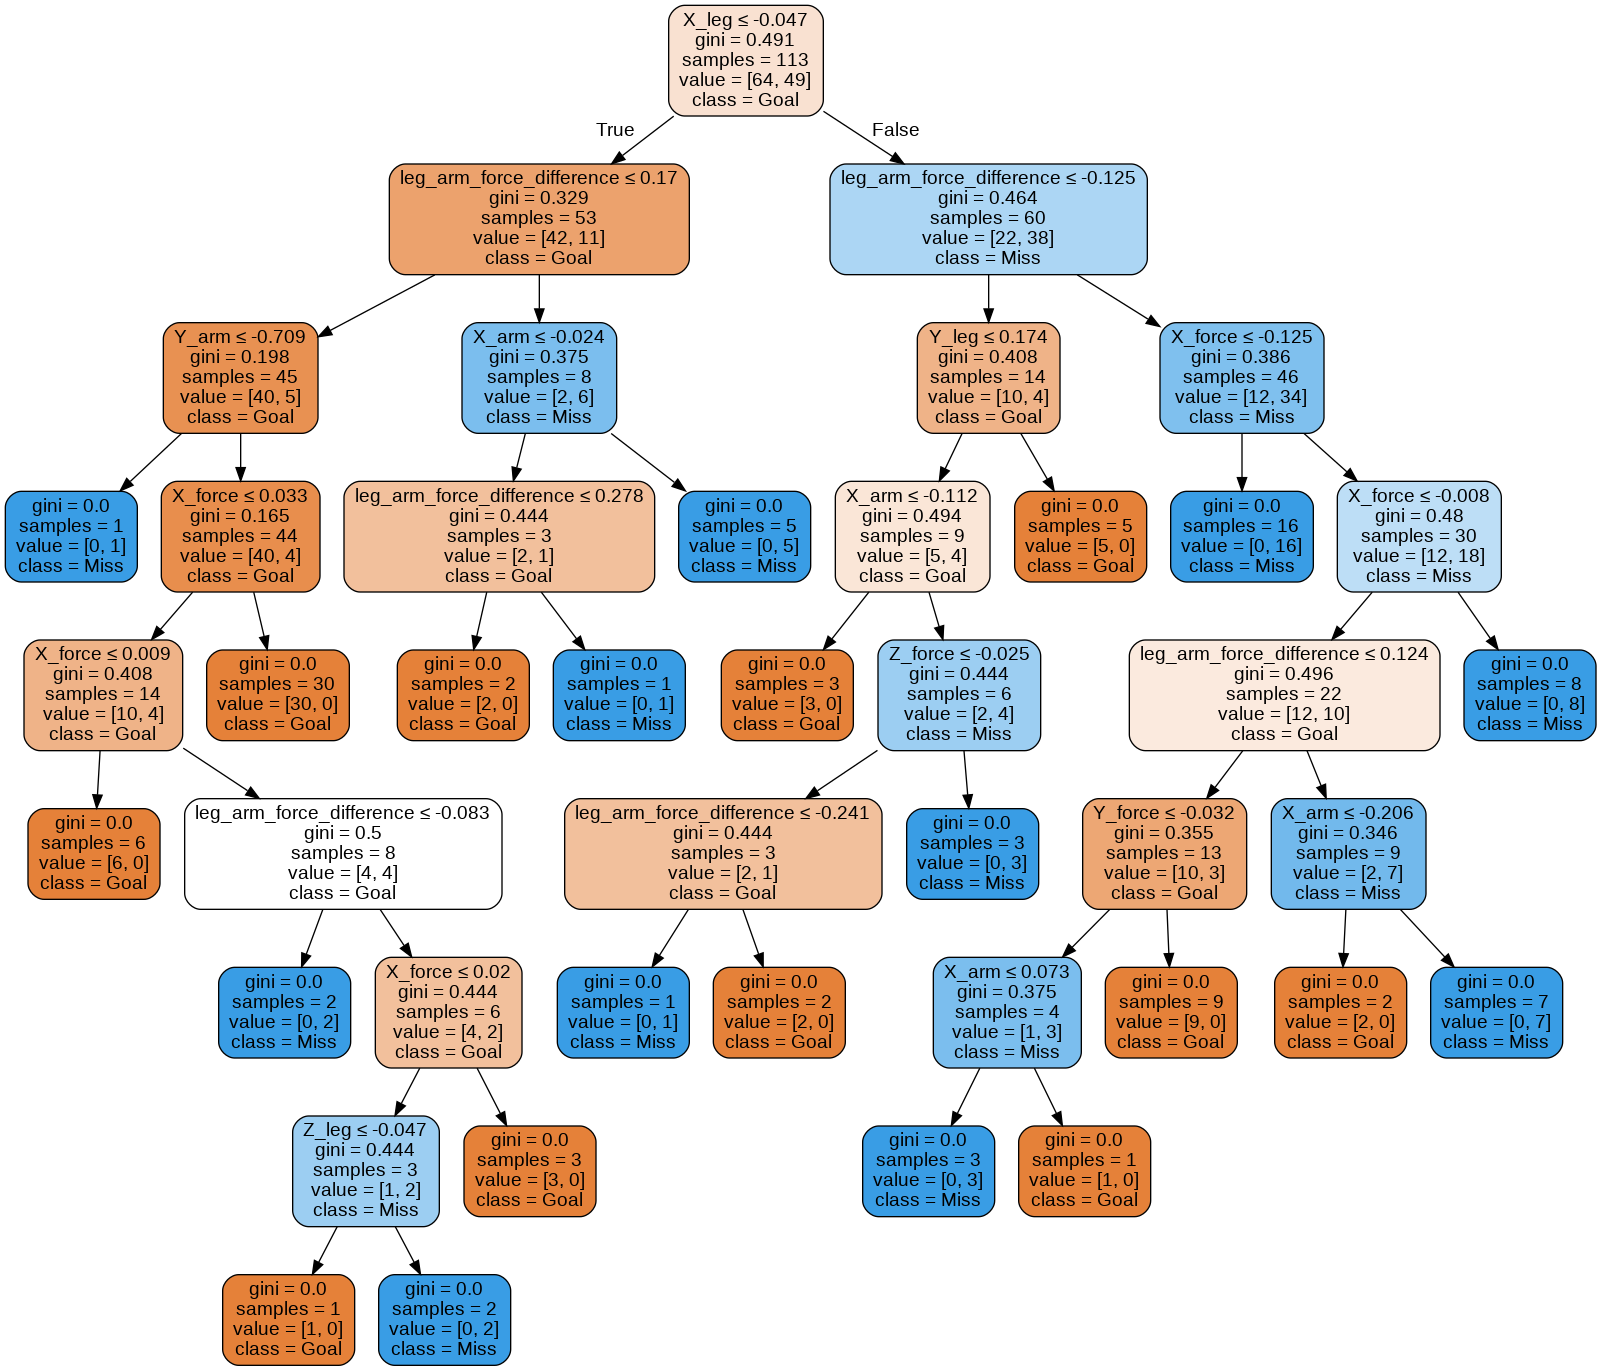

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = norm_X_train.columns,class_names=['Goal','Miss'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('basketball.png')
Image(graph.create_png())

In **Scikit-learn**, optimization of decision tree classifier performed by only pre-pruning. Maximum depth of the tree can be used as a control variable for pre-pruning. In the following we can plot a decision tree on the same data with max_depth=4. Other than pre-pruning parameters. We can also try other attribute selection measure such as entropy.


*   Well, the classification rate increased to 75%, which is better accuracy than the previous model.



In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(norm_X_train,Y_train)

#Predict the response for test dataset
y_pred = clf.predict(norm_X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.7586206896551724


**Visualizing Decision Trees with less Complexity**

This pruned model is less complex, explainable, and easy to understand than the previous decision tree model plot.

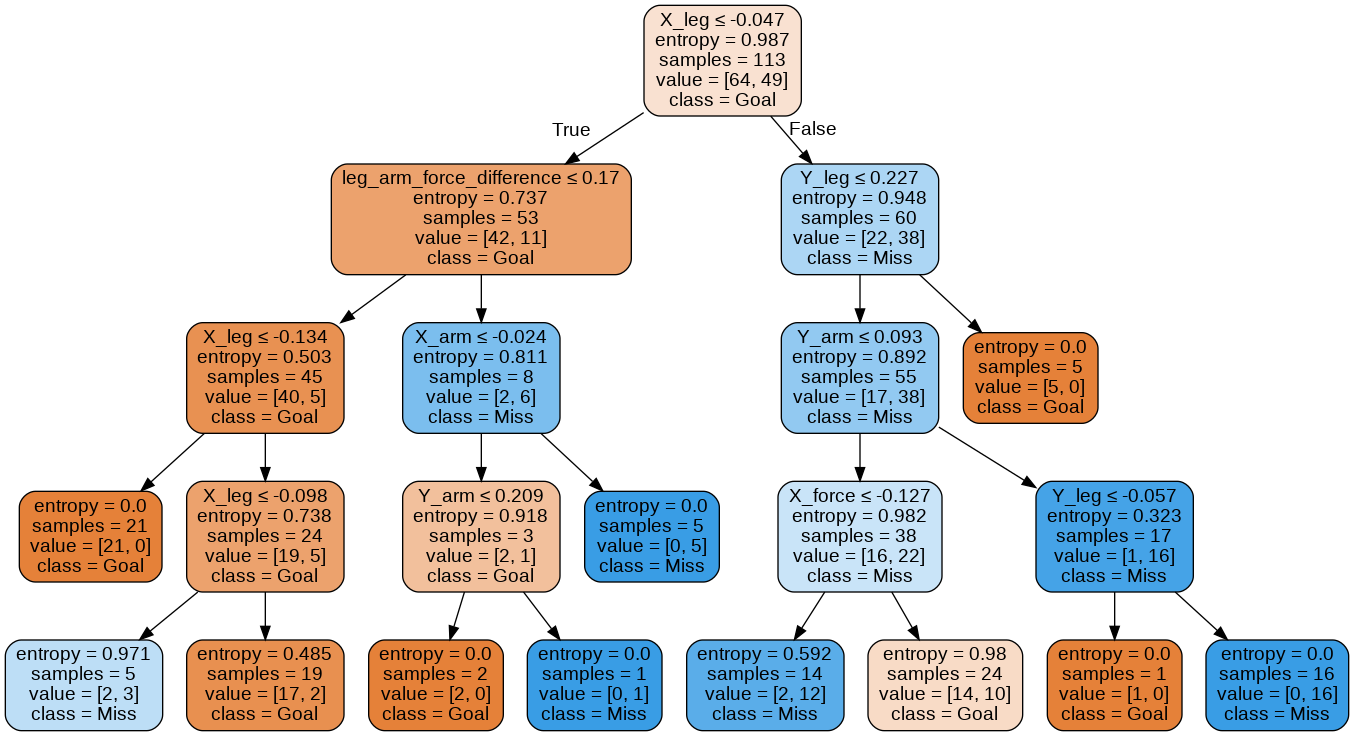

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = norm_X_train.columns,class_names=['Goal','Miss'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('basketball2.png')
Image(graph.create_png())

**Decision boundary Plot**

In [ ]:
col = list(norm_X_train.columns)

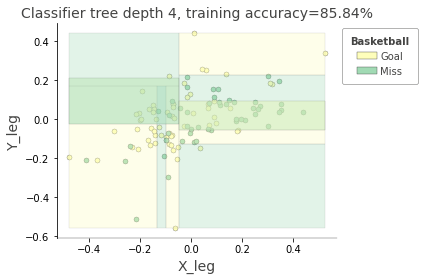

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *

ct = ctreeviz_bivar(clf, norm_X_train, Y_train,
                    feature_names = col,
                    class_names=["Goal", "Miss"],
                    target_name='Basketball')
plt.tight_layout()
plt.show()

Confusion matrix
[[14  2]
 [ 5  8]]


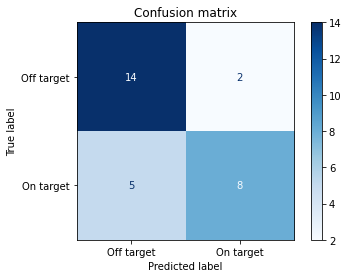

In [ ]:
#Define class names
class_names=("Off target","On target")
#Plot confusion matrix
title=("Confusion matrix")

disp = plot_confusion_matrix(clf, norm_X_test, Y_test,
                              display_labels=class_names,
                              cmap=plt.cm.Blues)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

**Random Forest Classifier**

Random forests are a combination of tree predictors such that each tree depends on the values of a random vector sampled independently and with the same distribution for all trees in the forest. The generalization error for forests converges a.s. to a limit as the number of trees in the forest becomes large. The generalization error of a forest of tree classifiers depends on the strength of the individual trees in the forest and the correlation between them. Internal estimates monitor error, strength, and correlation and these are used to show the response to increasing the number of features used in the splitting. Internal estimates are also used to measure variable importance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(norm_X_train, Y_train)
rf_predictions = rf_classifier.predict(norm_X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, rf_predictions))

Accuracy: 0.7931034482758621


**Feature Importance**

A big part of analysing our models post training is whether the features we used for training actually helped in predicting the target and by how much. Feature importance attribute outputs an array containing a value between 0 and 100 for each feature representing how useful the model found each feature in trying to predict the target. This gives us the opportunity to analyse what contributed to the accuracy of the model and what features were just noise. With this information we can check that the model is working as we would expect, discard features if we feel they are not adding any value and use it to hypothesis about new features that we could engineer for another iteration of the model.

In [ ]:
def plot_feature_importance(importance,names,model_type):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

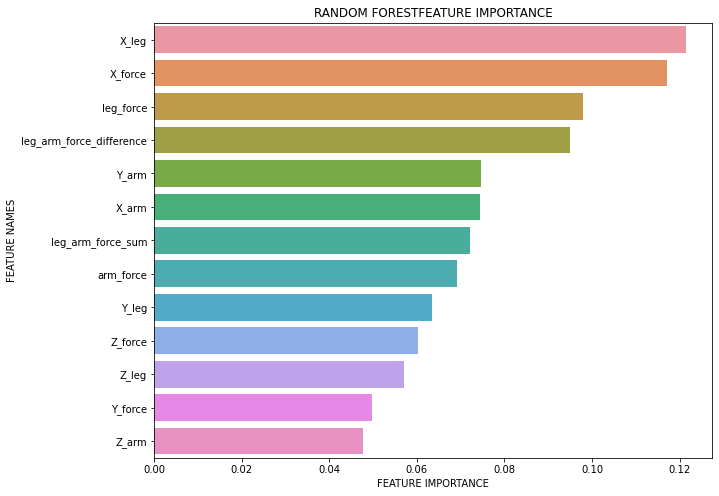

In [ ]:
plot_feature_importance(rf_classifier.feature_importances_,norm_X_train.columns,'RANDOM FOREST')

In [ ]:
# Model (can also use single decision tree)

estimator = rf_classifier.estimators_[50]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = norm_X_train.columns,
                class_names = ["GOAL", "MISS"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

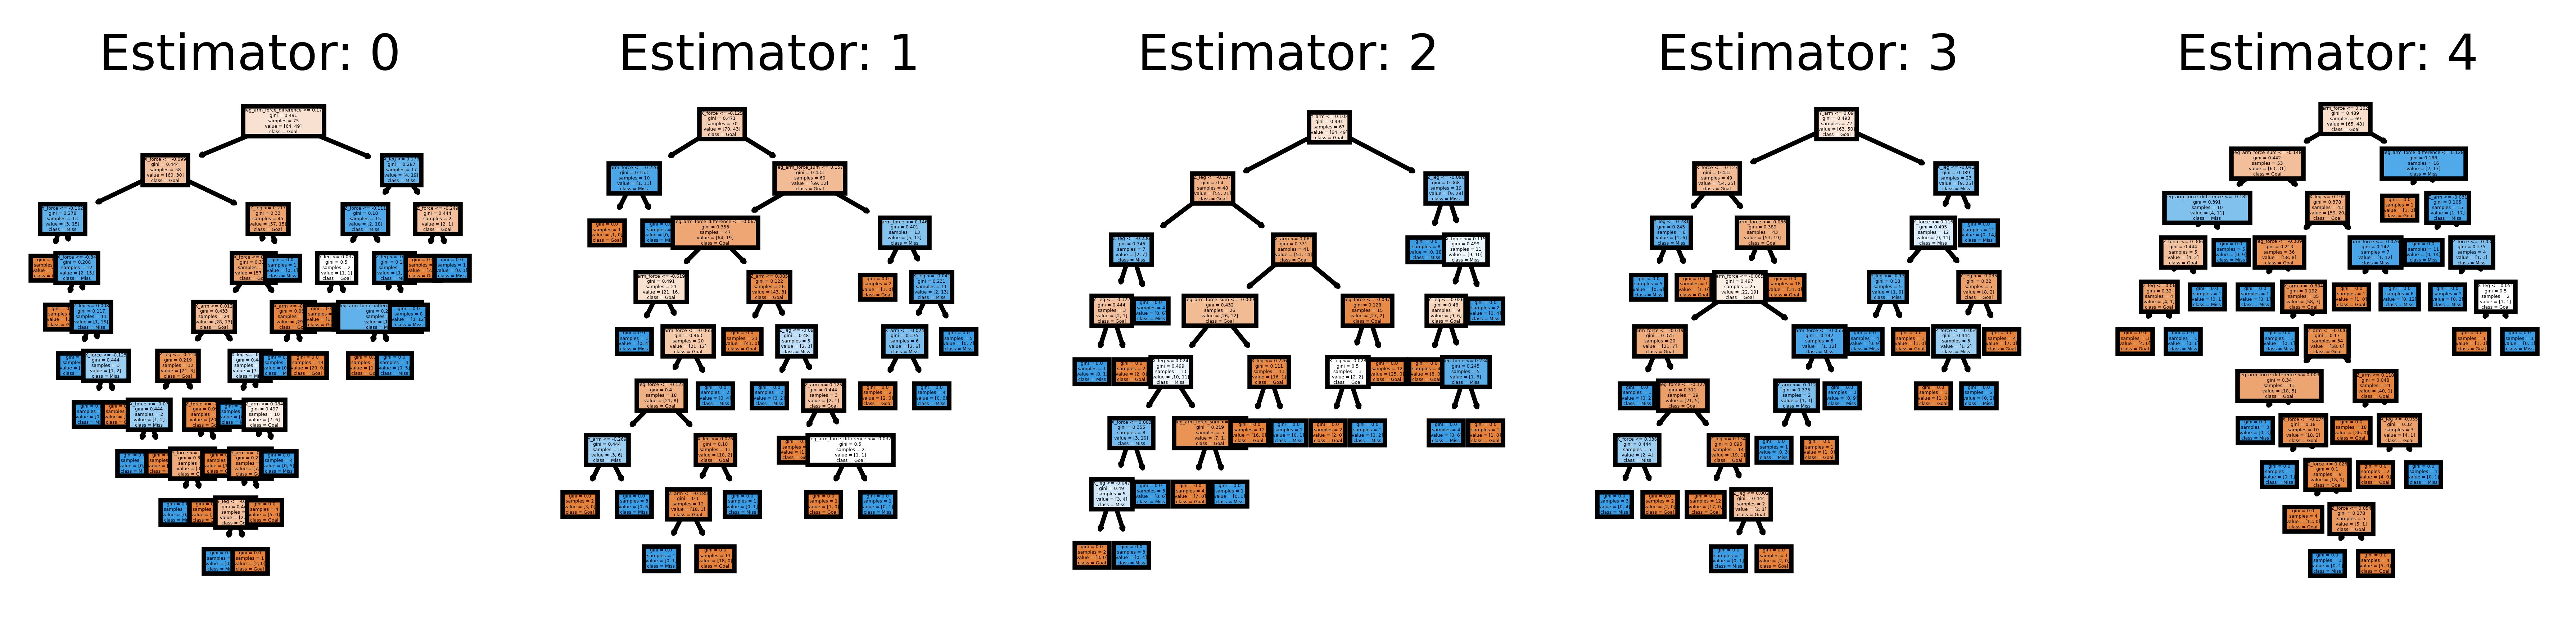

In [ ]:
# This may not the best way to view each estimator as it is small
fn=col
cn=["Goal", "Miss"]
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf_classifier.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

In [ ]:
classifier = tree.DecisionTreeClassifier(max_depth=4)  # limit depth of tree
classifier.fit(norm_X_train, fake_Y_train)

viz = dtreeviz(classifier,
              norm_X_train,
              fake_Y_train,
              target_name='Basketball',
              feature_names=col, 
              class_names=["Goal", "Miss"],
              fancy=True )  # fance=False to remove histograms/scatterplots from decision nodes
              
viz.save("rf.svg")

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


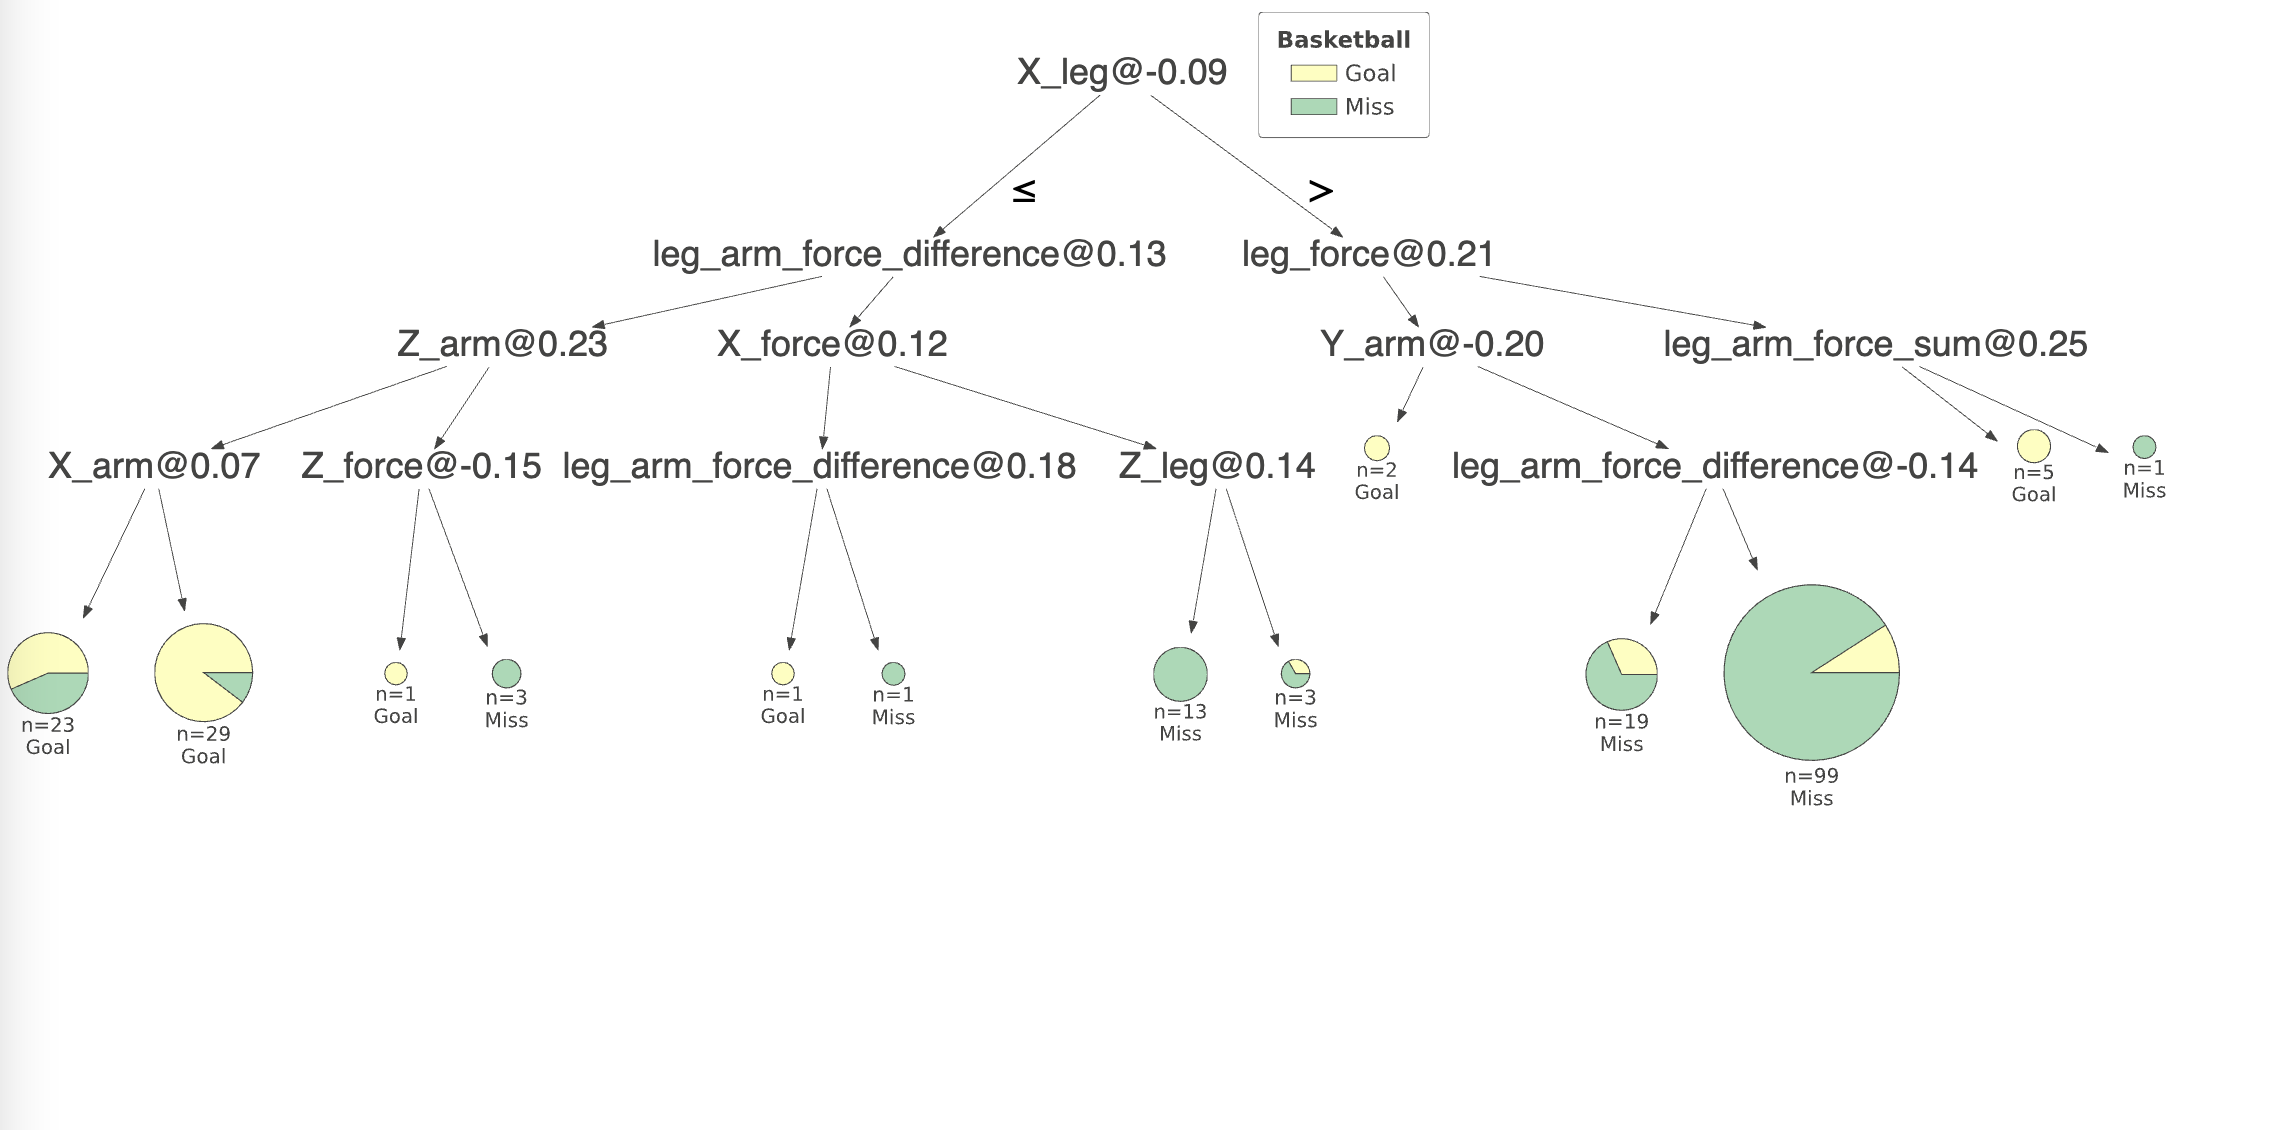

In [ ]:
classifier = tree.DecisionTreeClassifier(max_depth=4)  # limit depth of tree
classifier.fit(norm_X_train, fake_Y_train)

viz = dtreeviz(classifier, 
               norm_X_train, 
               fake_Y_train,
               target_name='Basketball',
               feature_names=col, 
               class_names=["Goal", "Miss"]  # need class_names for classifier
              )  
              
viz.save("rf2.svg")

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


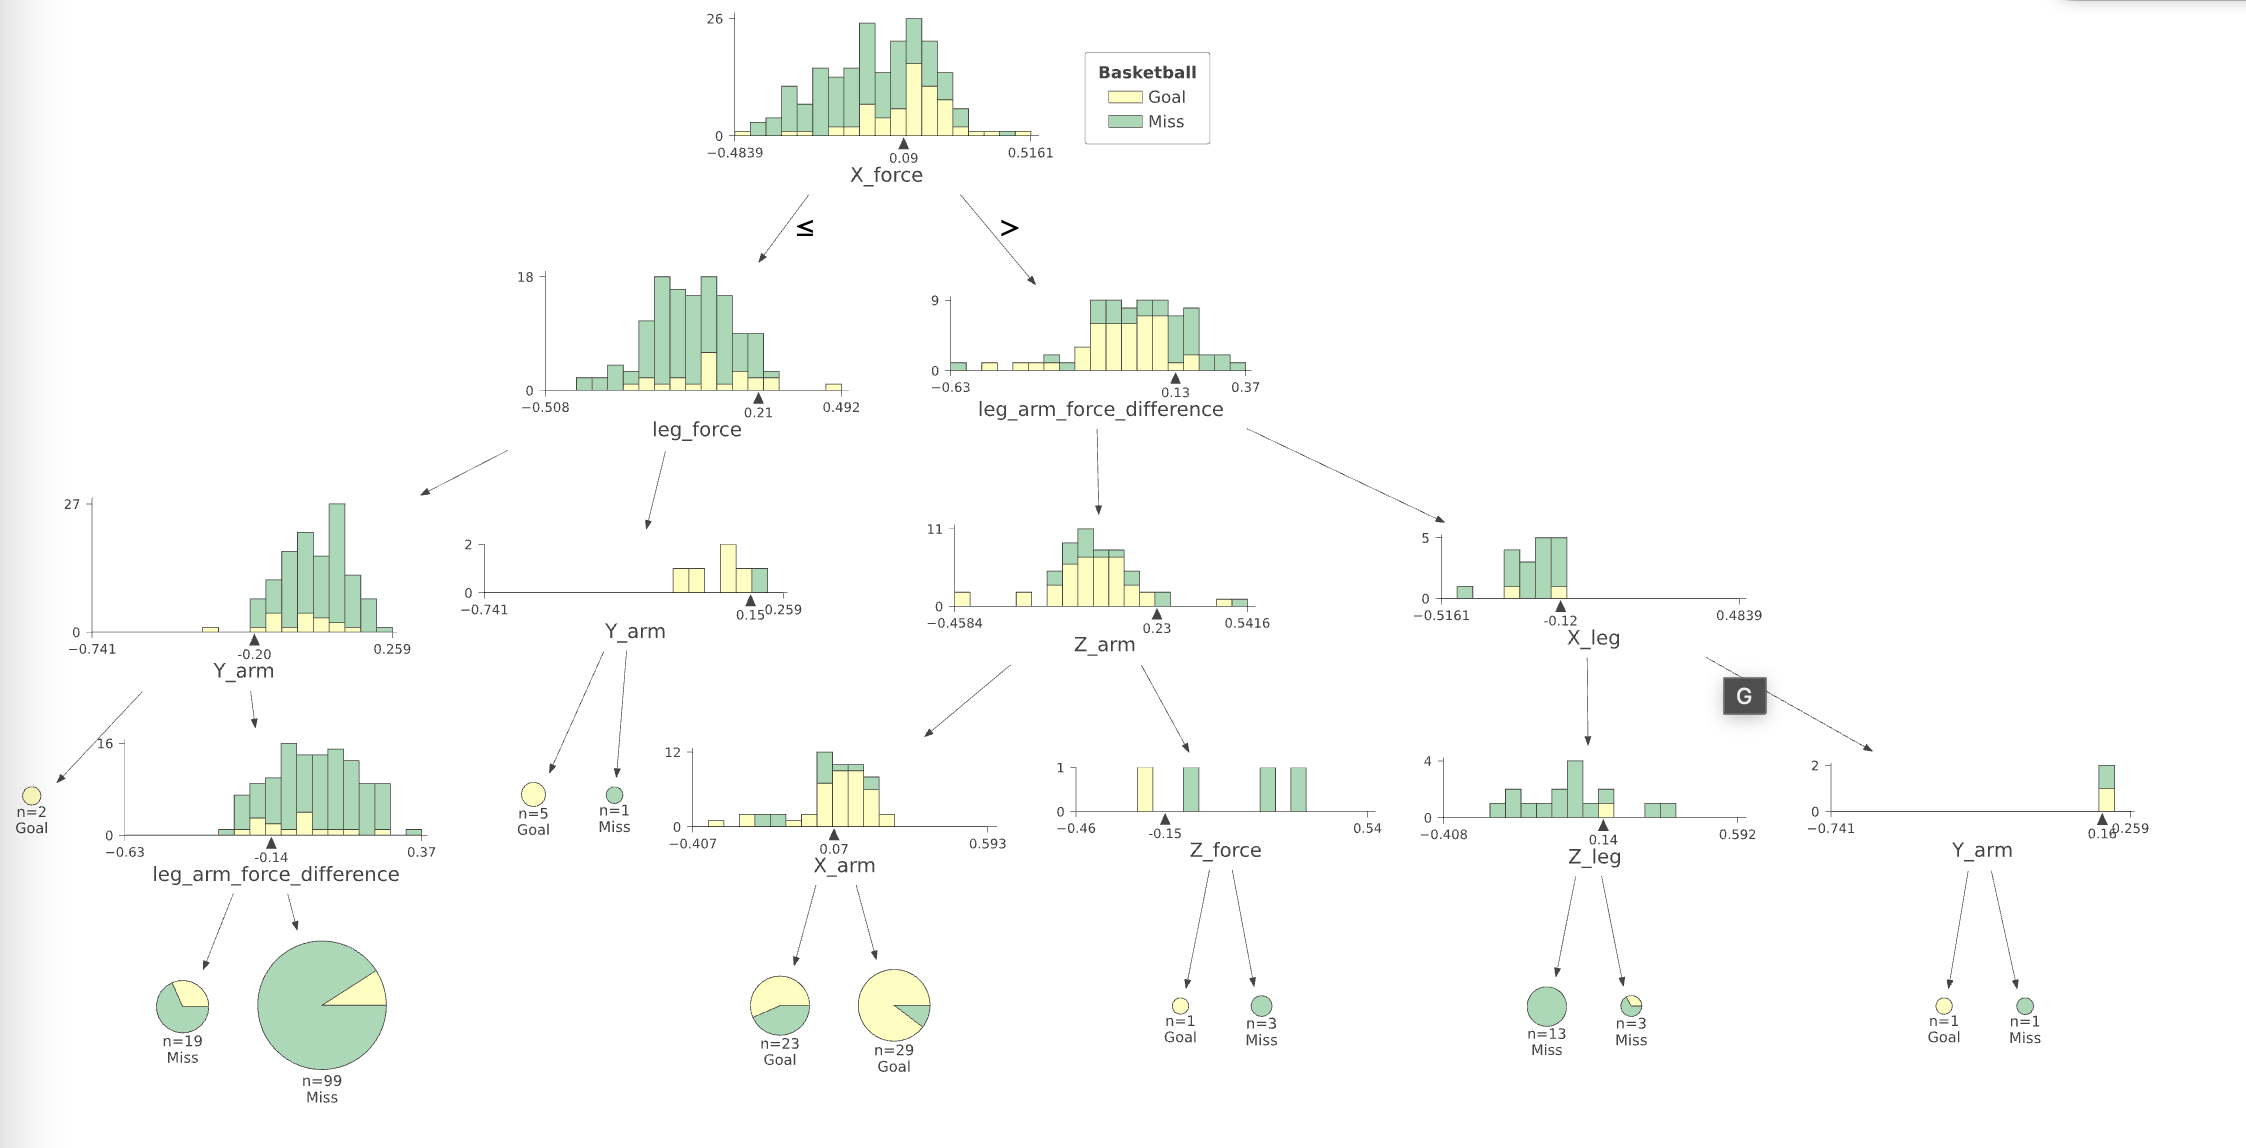

Confusion matrix
[[15  1]
 [ 5  8]]


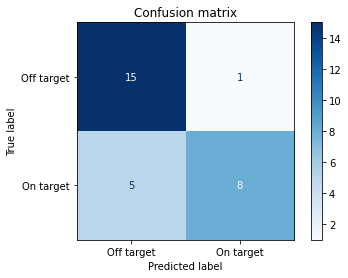

In [ ]:
#Define class names
class_names=("Off target","On target")
#Plot confusion matrix
title=("Confusion matrix")

disp = plot_confusion_matrix(rf_classifier, norm_X_test, Y_test,
                              display_labels=class_names,
                              cmap=plt.cm.Blues)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

**IML with Eli5**

ELI5 is a Python library which allows to visualize and debug various Machine Learning models using unified API. It has built-in support for several ML frameworks and provides a way to explain black-box models.

In [ ]:
eli5.show_weights(rf_classifier)

In [ ]:
eli5.show_prediction(rf_classifier, norm_X_test.iloc[2], feature_names = ['X_leg', 'Y_leg', 'Z_leg', 'X_arm', 'Y_arm', 'Z_arm', 'leg_force',
       'arm_force', 'leg_arm_force_sum', 'leg_arm_force_difference', 'X_force',
       'Y_force', 'Z_force'])

**IML with Shap**

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In [ ]:
# Need to load JS visualisation in the notebook
shap.initjs()

#assuming we are using XGBoost
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(norm_X_train)

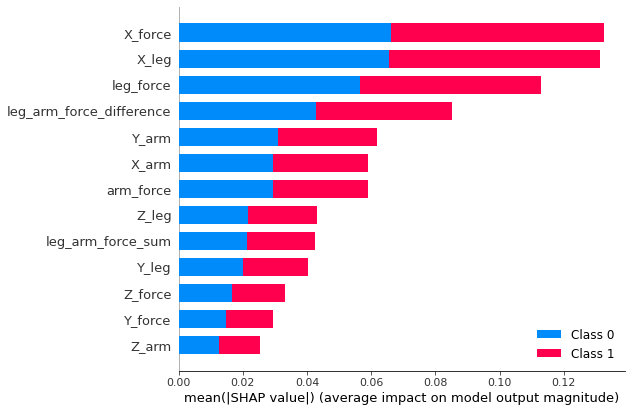

In [ ]:
shap.summary_plot(shap_values, features = norm_X_train, feature_names=['X_leg', 'Y_leg', 'Z_leg', 'X_arm', 'Y_arm', 'Z_arm', 'leg_force',
       'arm_force', 'leg_arm_force_sum', 'leg_arm_force_difference', 'X_force',
       'Y_force', 'Z_force'])